In [1]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt

# # Coordinates of Sere Wind Farm
# sere_lat = -31.6167
# sere_lon = 18.3487

# # Lists to collect data for all years
# all_wind_speeds = []
# all_times = []

# # Loop over each year and extract data
# for year in range(2018, 2023):
#     # Open dataset for the specific year
#     ds = xr.open_dataset(f'data_850/{year}_850_SA.nc')
#     ds.load()

#     # Calculate wind speed from u and v components
#     ds['wspd'] = np.sqrt(ds.u**2 + ds.v**2).astype(np.float32)

#     # Select the data closest to the Sere Wind Farm coordinates
#     sere_wind_data = ds.sel(latitude=sere_lat, longitude=sere_lon, method='nearest')

#     # Extract time and wind speed as numpy arrays
#     sere_wind_time = sere_wind_data['time'].values
#     sere_wind_np = sere_wind_data['wspd'].values

#     # Collect the data for concatenation
#     all_times.append(sere_wind_time)
#     all_wind_speeds.append(sere_wind_np)

#     # Plot the wind speed for the current year
#     plt.plot(sere_wind_time, sere_wind_np, label=f'{year}')

# # Concatenate all years' data into one array for a combined plot
# all_times = np.concatenate(all_times)
# all_wind_speeds = np.concatenate(all_wind_speeds)

# # Plotting the combined data for all years
# plt.plot(all_times, all_wind_speeds, label='2018-2022', color='black')

# plt.xlabel('Time')
# plt.ylabel('Wind Speed (m/s)')
# plt.title(f'Wind Speed at {sere_lat}°S, {sere_lon}°E (2018-2022)')
# plt.legend()
# plt.show()




In [2]:
# df = pd.DataFrame({
#     'Time': all_times,
#     'Wind Speed (m/s)': all_wind_speeds
# })

# # Save the DataFrame to a CSV file
# df.to_csv('sere_wind_speeds_2018_2022.csv', index=False)

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import Trainer

import wandb
from lightning.pytorch.loggers import WandbLogger

from typing import Tuple

df = pd.read_csv('data_850\sere_wind_speeds_2018_2022.csv')

In [4]:
# np_arr = np.sin(np.linspace(0, 10000, len(df)) + 1 * 10)
# df['wspd'] = np_arr

# random_frequency = np.random.uniform(0.1, 5) 
# random_phase = np.random.uniform(0, 2 * np.pi)
# np_arr = np.sin(np.linspace(0, 10000, len(df)) * random_frequency + random_phase)
# noise = np.random.normal(0, 0.5, len(df))  
# np_arr_noisy = np_arr + noise
# df['wspd'] = np_arr_noisy


In [202]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=10, steps_ahead=1, data_split='train', intervals = 1):
        self.window_size = window_size
        self.steps_ahead = steps_ahead
        self.df = df

        self.mean = self.df['wspd'].mean()
        self.std = self.df['wspd'].std()

        self.data_split = data_split

        self.intervals = intervals

        self.split_data()
        self.normalize_data(std=False)
 
    def __len__(self) -> int:
        """
        Returns the number of samples based on how many windows of size `window_size + steps`
        can fit into the dataset for the specified split.

        Returns:
            int: The number of valid windows that can fit into the specified dataset split.
        """

        if self.data_split == 'train':
            dataset_length = len(self.X_train)
        elif self.data_split == 'val':
            dataset_length = len(self.X_val)
        elif self.data_split == 'test':
            dataset_length = len(self.X_test)
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
        
        total_window_size = (self.window_size + self.steps_ahead)  * self.intervals
        num_windows = dataset_length - total_window_size + self.intervals  
        
        return max(0, num_windows)  

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves a sample from the specified dataset split.

        Args:
            idx (int): The index of the sample to retrieve.
            data_split (str): The dataset split ('train', 'val', 'test'). Default is 'train'.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing features, forcings, and target.
        """

        if self.data_split == 'train':
            x = self.X_train_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_train_t[idx + self.window_size * self.intervals]
            y = self.X_train_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        elif self.data_split == 'val':
            x = self.X_val_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_val_t[idx + self.window_size * self.intervals]
            y = self.X_val_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        elif self.data_split == 'test':
            x = self.X_test_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_test_t[idx + self.window_size * self.intervals]
            y = self.X_test_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
        
    def split_data(self, train_size=0.8, val_size=0.1):
        wspd_data = self.df['wspd']
        time_values = df['Time'].values
        time_values = pd.to_datetime(time_values)

        forcings = np.stack([time_values.hour, time_values.month], axis=-1)

        self.X_train, self.X_test = train_test_split(wspd_data, train_size=train_size, shuffle=False)
        self.X_train, self.X_val = train_test_split(self.X_train, test_size=val_size, shuffle=False)

        self.F_train, self.F_test = train_test_split(forcings, train_size=train_size, shuffle=False)
        self.F_train, self.F_val = train_test_split(self.F_train, test_size=val_size, shuffle=False)        

    def normalize_data(self, std = True):

        if std:
            self.X_train_t = (self.X_train - self.mean) / self.std
            self.X_val_t = (self.X_val - self.mean) / self.std
            self.X_test_t = (self.X_test - self.mean) / self.std
        else:
            self.X_train_t = (self.X_train - self.X_train.min()) / (self.X_train.max() - self.X_train.min())
            self.X_val_t = (self.X_val - self.X_val.min()) / (self.X_val.max() - self.X_val.min())
            self.X_test_t = (self.X_test - self.X_test.min()) / (self.X_test.max() - self.X_test.min())

        self.X_train_t = torch.tensor(self.X_train_t.values, dtype=torch.float32)
        self.X_val_t = torch.tensor(self.X_val_t.values, dtype=torch.float32)
        self.X_test_t = torch.tensor(self.X_test_t.values, dtype=torch.float32)

        self.F_train_t = torch.tensor(self.F_train, dtype=torch.float32)
        self.F_val_t = torch.tensor(self.F_val, dtype=torch.float32)
        self.F_test_t = torch.tensor(self.F_test, dtype=torch.float32)

    def test_class(self) -> None:
        print('self.X_train:', self.X_train.shape, 'self.X_val:', self.X_val.shape, 'self.X_test:', self.X_test.shape)
        print('self.F_train:', self.F_train.shape, 'self.F_val:', self.F_val.shape, 'self.F_test:', self.F_test.shape)

        print('self.X_train_t:', self.X_train_t.shape, 'self.X_val_t:', self.X_val_t.shape, 'self.X_test_t:', self.X_test_t.shape)
        print('self.F_train_t:', self.F_train_t.shape, 'self.F_val_t:', self.F_val_t.shape, 'self.F_test_t:', self.F_test_t.shape)

    def plot_predictions(self, model, seed = 0, xgboost = False):
        x = self.X_test_t[seed:seed + self.window_size * self.intervals:self.intervals].reshape(1, -1)
        F = self.F_test_t[seed + self.window_size * self.intervals].reshape(1, -1)
        y = self.X_test_t[seed + self.window_size  * self.intervals:seed + (self.window_size + self.steps_ahead)  * self.intervals:self.intervals]

        if xgboost:
            x_np = x.numpy()
            F_np = F.numpy()    
            input_data = np.concatenate([x_np, F_np], axis=-1)
            predictions = model.predict(input_data)
        else:
            prediction = model(x)#, , F            
            predictions = prediction.detach().numpy()
        
        plt.plot(range(self.window_size), x[0], label='Input')
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), y, label='Target')
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), predictions[0], label='Prediction')

        plt.title('Wind Speed Prediction')
        plt.xlabel('Time')
        plt.ylabel('Wind Speed (m/s)')
        plt.legend()

        plt.show()

    def auto_regressive(self, model, x, F):
        predictions = []
        for i in range(round(self.steps_ahead)):
            # print('Step: ', i)
            y_hat = model(x, F)

            x = torch.cat([x[1:], y_hat], dim=-1)
            
            hour = F[0,].item()  
            month = F[1].item()  
                
            hour += 1
            if hour == 24:
                hour = 0
            
            F = torch.tensor([[hour, month]]).float().squeeze()
            predictions.append(y_hat)

        return torch.stack(predictions)

In [197]:
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, forcing_size, output_size, hidden_size = 512, lr = 0.0001, steps = 1, rollout = False, interval = 1, weights = False):
        super(SimpleMLP, self).__init__()
        self.save_hyperparameters()

        self.fc1 = nn.Linear(input_size + forcing_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.rollout = rollout

        self.dropout = nn.Dropout(p=0.2)

        self.interval = interval

        if self.rollout:
            output_size = 1
            
        self.fc_out = nn.Linear(hidden_size, output_size) 

        self.loss_fn = nn.MSELoss()

        self.steps = steps

        self.lr = lr

        if weights:
            self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  
            if m.bias is not None:
                nn.init.constant_(m.bias, 0) 

    def forward(self, X, F):
        if self.rollout:
            return self.rollout_step(X, F)
        else:
            return self.single_step(X, F)
        
    def single_step(self, x, F):
        inputs = torch.cat((x, F), dim=-1)  

        x = torch.relu(self.fc1(inputs)) 
        # x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc_out(x)  

        return x
    
    def rollout_step(self, x, F):
        y_outputs = []
        for step in range(self.steps):

            y_hat = self.single_step(x, F)

            x = torch.cat((x[:, 1:], y_hat), dim=1)

            hour = F[:, 0]
            month = F[:, 1]
            
            hour = (hour + self.interval) % 24

            F = torch.stack((hour, month), dim=1).float()

            y_outputs.append(y_hat)

        return torch.stack(y_outputs, dim=1).reshape(-1, self.steps)
    
    def training_step(self, batch, batch_idx):
        x, F, y = batch  

        if self.rollout:
            loss = self.auto_rollout(x, F, y)
        else:
            y_hat = self(x, F)
            loss = 0.0
            for i in range(y.shape[1]):
                loss += self.loss_fn(y_hat[:, i], y[:, i])
            # loss = self.loss_fn(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, F, y = batch  

        if self.rollout:
            loss = self.auto_rollout(x, F, y)
        else:
            y_hat = self(x, F)
            loss = 0.0
            for i in range(y.shape[1]):
                loss += self.loss_fn(y_hat[:, i], y[:, i])
            # loss = self.loss_fn(y_hat, y)


        self.log("val_loss", loss, on_step=False, on_epoch=True) 
        return loss
    
    def test_step(self, batch, batch_idx):
        x, F, y = batch  

        if self.rollout:
            loss = self.auto_rollout(x, F, y)
        else:
            y_hat = self(x, F)
            loss = self.loss_fn(y_hat, y)


        self.log("val_loss", loss, on_step=False, on_epoch=True) 
        return loss
    
    def auto_rollout(self, x, F, y):

        cumulative_loss = 0.0
        current_input = x.clone()
        current_F = F.clone()


        for step in range(self.steps): 
            # print('Step: ', step)
            
            y_hat = self.single_step(current_input, current_F)

            loss = self.loss_fn(y_hat, y[:, step].reshape(-1, 1))
            cumulative_loss += loss  
            
            current_input = torch.cat((current_input[:, 1:], y_hat), dim=1)

            hour = current_F[:, 0]
            month = current_F[:, 1]
            
            hour = (hour + self.interval) % 24

            current_F = torch.stack((hour, month), dim=1).float()

        return cumulative_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr= self.lr, weight_decay=1e-5)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}
    

class TimeSeriesModel(L.LightningModule):
    def __init__(self, input_dim=1, hidden_dim=150, output_dim=1, steps = 1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

        self.steps = steps
        self.input_dim = input_dim

        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        x = x.reshape(-1, 1, self.input_dim)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

    def training_step(self, batch, batch_idx):
        x, _, y = batch

        y_hat = self(x)

        loss = self.loss_fn(y_hat, y)

        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _, y = batch

        y_hat = self(x)

        loss = self.loss_fn(y_hat, y)

        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, _, y = batch

        y_hat = self(x)

        loss = self.loss_fn(y_hat, y)

        self.log('test_loss', loss)
        return loss
    
    
    def auto_rollout(self, x, y):

        cumulative_loss = 0.0
        current_input = x.clone()


        for step in range(self.steps): 
            # print('Step: ', step)
            
            y_hat = self(current_input)

            loss = self.loss_fn(y_hat, y[:, step].reshape(-1, 1))
            cumulative_loss += loss  
            
            current_input = torch.cat((current_input[:, 1:], y_hat), dim=1)

        return cumulative_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002)

Epoch 0: 100%|██████████| 246/246 [01:14<00:00,  3.30it/s, v_num=hcxs] 


c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\wandb\sdk\wandb_run.py:2382: UserWarning: Run (0d5atssy) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),


In [185]:
window_size = 24 * 2
steps_ahead = 24
interval = 2

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, intervals=interval)

Shapes:	 torch.Size([32, 36]) torch.Size([32, 2]) torch.Size([32, 12])
Output:	 torch.Size([32, 12])
Current Input: torch.Size([32, 36]) Y_hat: torch.Size([32, 12]) Y: torch.Size([32, 1])
Loss training: tensor(0.0302, grad_fn=<AddBackward0>)


c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\core\module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


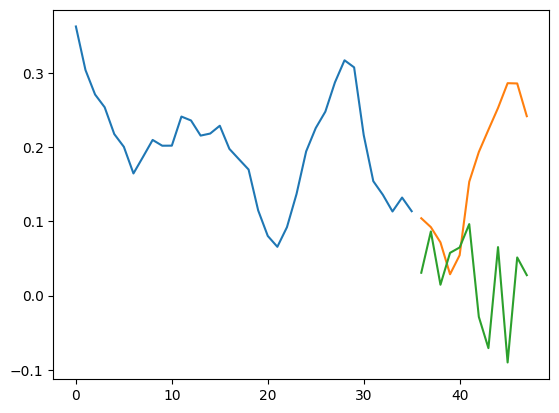

In [176]:
# Explanation

# window_size = 48
# steps_ahead = 24
# interval = 2


train_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval), batch_size=32, shuffle=False) 

for batch in train_loader:
    x, F, y = batch
    print('Shapes:\t', x.shape, F.shape, y.shape)
    break

model = TimeSeriesModel(input_dim=window_size, hidden_dim=128, output_dim=12)

y_hat = model(x)

print('Output:\t', y_hat.shape)

print('Loss training:', model.training_step((batch), 0))


plt.plot(range(window_size), x[0])
plt.plot(range(window_size, window_size + steps_ahead), y[0])
plt.plot(range(window_size, window_size + steps_ahead), y_hat[0].detach().numpy())

plt.show()

In [30]:
time_series.test_class()

self.X_train: (31553,) self.X_val: (3506,) self.X_test: (8765,)
self.F_train: (31553, 2) self.F_val: (3506, 2) self.F_test: (8765, 2)
self.X_train_t: torch.Size([31553]) self.X_val_t: torch.Size([3506]) self.X_test_t: torch.Size([8765])
self.F_train_t: torch.Size([31553, 2]) self.F_val_t: torch.Size([3506, 2]) self.F_test_t: torch.Size([8765, 2])


In [198]:
window_size = 12 * 3
steps_ahead = 12
interval = 2
batch_size = 128

model = TimeSeriesModel(input_dim=window_size, hidden_dim=128, output_dim=12)
# model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=steps_ahead, hidden_size=128, lr=0.0001, steps=1, rollout=True, interval=interval, weights=True)
# model = SimpleMLP.load_from_checkpoint('time-series-forecasting/unar4d4t/checkpoints\SimpleMLP_36_3_at_2_LR_0.0001_Rollout.ckpt', input_size=window_size, 
#                                        forcing_size=2, output_size=1, lr=0.0001, steps=1, rollout=True)

model.steps = steps_ahead

log_name = f"SimpleMLP_{window_size}_{steps_ahead}_at_{interval}_LSTM"

train_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval), 
                          batch_size=batch_size, shuffle=True)  

val_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='val', intervals=interval), 
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='test', intervals=interval),
                            batch_size=batch_size, shuffle=False)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename=log_name,  save_top_k=1, mode='min')
early_stop_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=True)

# trainer = Trainer(max_epochs=100, 
#                   callbacks=[checkpoint_callback, early_stop_callback])


wandb_logger = WandbLogger(project="time-series-forecasting", name=log_name)

trainer = Trainer(max_epochs=200, 
                  callbacks=[checkpoint_callback, early_stop_callback], 
                  logger=wandb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [199]:
trainer.fit(model, train_loader, val_loader)

trainer.test(model, test_loader)

wandb.finish()

c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory .\time-series-forecasting\hwtbhcxs\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 85.0 K | train
1 | fc      | Linear  | 1.5 K  | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
86.5 K    Trainable params
0         Non-trainable params
86.5 K    Total params
0.346     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in e

c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 246/246 [00:01<00:00, 195.60it/s, v_num=hcxs]

Metric val_loss improved. New best score: 0.022


Epoch 1: 100%|██████████| 246/246 [00:01<00:00, 196.36it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Epoch 3: 100%|██████████| 246/246 [00:01<00:00, 211.83it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Epoch 6: 100%|██████████| 246/246 [00:01<00:00, 201.00it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Epoch 9: 100%|██████████| 246/246 [00:01<00:00, 207.24it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Epoch 13: 100%|██████████| 246/246 [00:01<00:00, 208.46it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Epoch 14: 100%|██████████| 246/246 [00:01<00:00, 205.13it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Epoch 16: 100%|██████████| 246/246 [00:01<00:00, 210.79it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Epoch 21: 100%|██████████| 246/246 [00:01<00:00, 204.91it/s, v_num=hcxs]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Epoch 36: 100%|██████████| 246/246 [00:01<00:00, 204.19it/s, v_num=hcxs]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.020. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 246/246 [00:01<00:00, 203.93it/s, v_num=hcxs]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\divanvdb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 533.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01613546907901764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▃▄▄▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
test_loss,▁
train_loss,▆▇▇▂▃▃▄▂▂▄▃▄▃▃▄▃▄▃▄▂▅▃▂▃▃▄▃▃▃▄█▅▄▃▂▁▂▂▂▄
trainer/global_step,▁▁▁▂▂▃▃▃▄▄▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
val_loss,▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂▃▂▂▁▂▂▁▇██▇▇▇▇▇▇▇▇▇▇
epoch,37
test_loss,0.01614
train_loss,0.00854
trainer/global_step,9102
val_loss,0.02095


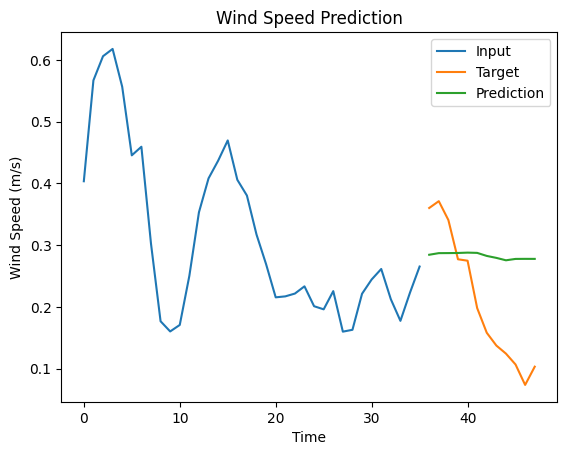

In [205]:
# window_size = 24 * 4
steps_ahead = 12
# interval = 2

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, intervals=interval)
# model = SimpleMLP.load_from_checkpoint('time-series-forecasting/eyht1rkc/checkpoints/SimpleMLP_96_5_at_1_Smaller_128by4.ckpt', input_size=window_size, 
#                                        forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)

model.to('cpu')
model.steps = steps_ahead
model.rollout = False

time_series.plot_predictions(model, seed=200)

In [162]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval)

loader = DataLoader(time_series, batch_size=30000, shuffle=True) 

for x, F, y in loader:
    print('Shapes:\t', x.shape, F.shape, y.shape)
    x_np = x.numpy()
    F_np = F.numpy()
    y_np = y.numpy()

    
    input_data = np.concatenate([x_np, F_np], axis=-1)
    print('Input Data:', input_data.shape, 'Output Data:', y_np.shape)
    xg_reg.fit(input_data, y_np)
    break

Shapes:	 torch.Size([30000, 96]) torch.Size([30000, 2]) torch.Size([30000, 24])
Input Data: (30000, 98) Output Data: (30000, 24)


In [230]:
# window_size = 24 * 4
steps_ahead = 24
# interval = 2

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, intervals=interval)
# model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)
model_1 = SimpleMLP.load_from_checkpoint('time-series-forecasting/0x8d792h/checkpoints/SimpleMLP_96_1_at_1_MMScaling.ckpt', input_size=window_size, 
                                       forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)

model_5 = SimpleMLP.load_from_checkpoint('time-series-forecasting/y6oa6lz9/checkpoints/SimpleMLP_96_5_at_1_MMScaling.ckpt', input_size=window_size, 
                                       forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)

model_10 = SimpleMLP.load_from_checkpoint('time-series-forecasting\mj7zyalz\checkpoints\SimpleMLP_96_10_at_1_MMScaling.ckpt', input_size=window_size,
                                        forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)

model_15 = SimpleMLP.load_from_checkpoint('time-series-forecasting\i7otkosf\checkpoints\SimpleMLP_96_15_at_1_MMScaling.ckpt', input_size=window_size,   
                                        forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=True)

model_24 = SimpleMLP.load_from_checkpoint('time-series-forecasting\ialggb92\checkpoints\SimpleMLP_96_24_at_1_MMScaling.ckpt', input_size=window_size,   
                                        forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=1, rollout=False)


model_1.to('cpu')
model_1.steps = steps_ahead

model_5.to('cpu')
model_5.steps = steps_ahead

model_10.to('cpu')
model_10.steps = steps_ahead

model_15.to('cpu')
model_15.steps = steps_ahead

model_24.to('cpu')
model_24.steps = steps_ahead


PyTorch 1 Step


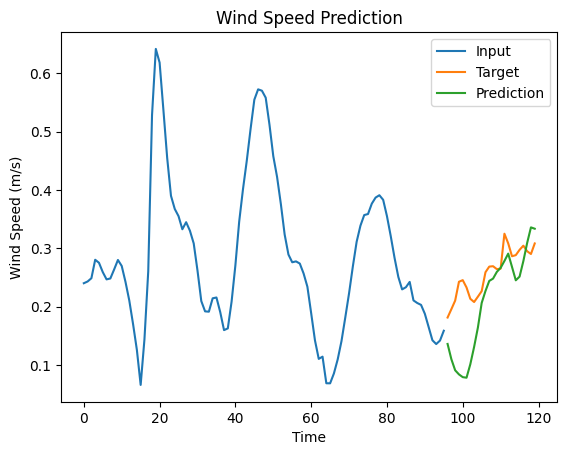

PyTorch 5 Steps


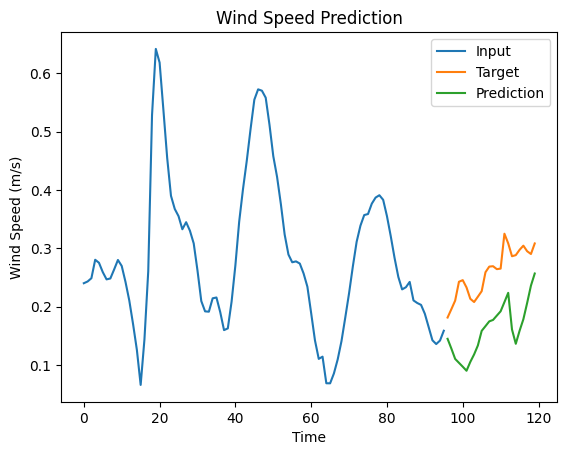

PyTorch 10 Steps


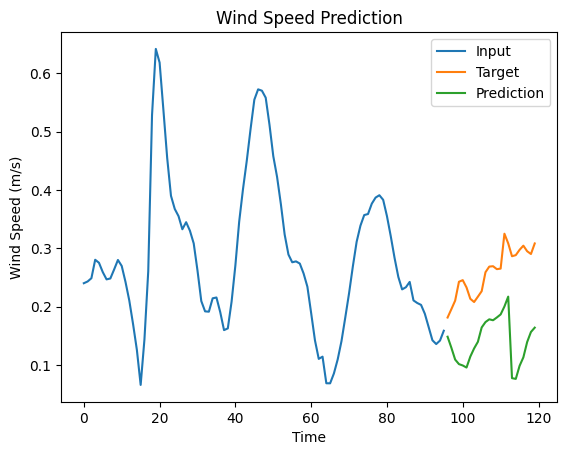

PyTorch 15 Steps


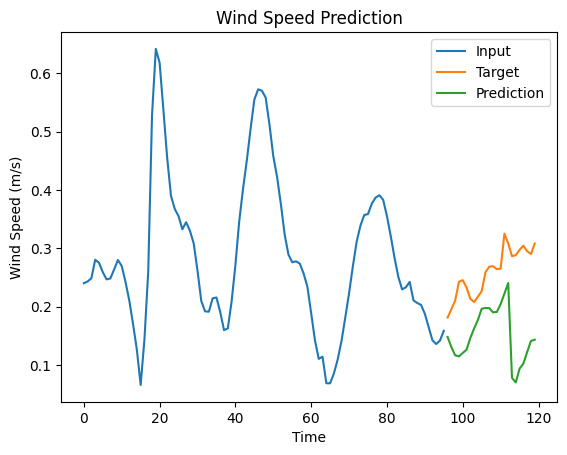

PyTorch 24 Steps


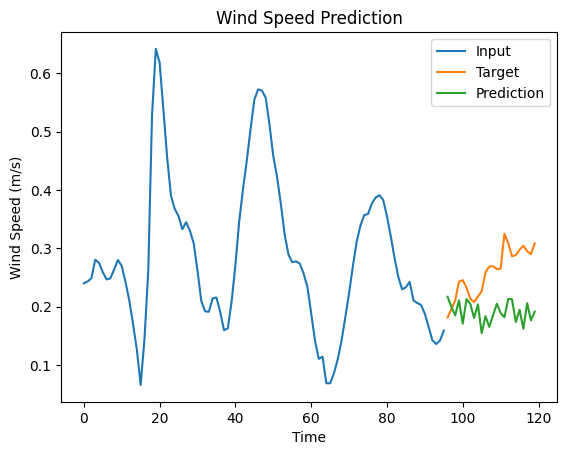

XGBoost


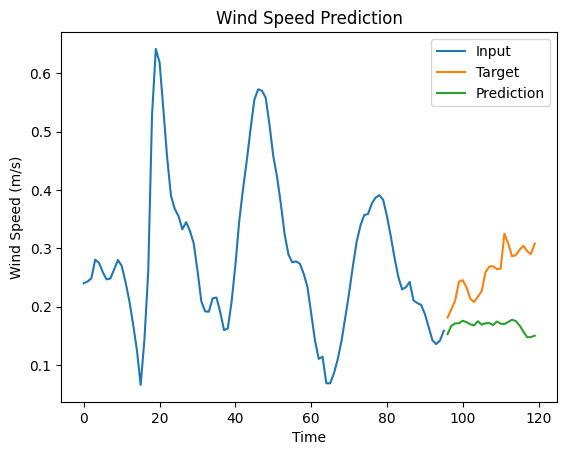

In [239]:
seed += 50
print('PyTorch 1 Step')
time_series.plot_predictions(model_1, seed=seed)

print('PyTorch 5 Steps')
time_series.plot_predictions(model_5, seed=seed)

print('PyTorch 10 Steps')
time_series.plot_predictions(model_10, seed=seed)

print('PyTorch 15 Steps')
time_series.plot_predictions(model_15, seed=seed)

print('PyTorch 24 Steps')
time_series.plot_predictions(model_24, seed=seed)

print('XGBoost')
time_series.plot_predictions(xg_reg, seed=seed, xgboost=True)